# I-Forest Based Unsupervised Model
**Links Used:**\
[Scikit-Learn IForests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)\
[IForest Outlier Detection on KDD'99 Dataset](https://docs.seldon.io/projects/alibi-detect/en/latest/examples/od_if_kddcup.html)\
[Someone's Notebook on a IForest Model](https://github.com/Apress/beginning-anomaly-detection-using-python-based-dl/blob/master/Isolation%20Forest%20KDDCUP%201999%20final.ipynb)

In [1]:
## Import everything, define parameters and dropped features.
# Load the prepared data and apply variance threshold to it.

import pandas as pd
import numpy as np
from common_stage import prepareData
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Hyperparameters
hyperparams = {
    'n_estimators': 100,
    'contamination': 'auto',
    'max_samples': 0.4,
    'max_features': 0.1
}

# Features to be dropped
dropped_features = [
    'srv_count', 'srv_serror_rate', 'srv_rerror_rate',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'
]

# Load and preprocess data
x_train, y_train, x_test, y_test = prepareData(scaling='standard', removed_features=dropped_features)

# Apply variance threshold
# It removes all low-variance features
selector = VarianceThreshold(0.01)
x_train = pd.DataFrame(selector.fit_transform(x_train), columns=x_train.columns[selector.get_support()])
x_test = pd.DataFrame(selector.transform(x_test), columns=x_train.columns)
print(x_train.head(5))

   duration  src_bytes  dst_bytes  wrong_fragment    urgent     count  \
0 -0.067783  -0.002879   0.138672       -0.047723 -0.002282 -1.521687   
1 -0.067783  -0.002820  -0.011564       -0.047723 -0.002282 -1.521687   
2 -0.067783  -0.002824   0.014192       -0.047723 -0.002282 -1.521687   
3 -0.067783  -0.002840   0.014192       -0.047723 -0.002282 -1.531071   
4 -0.067783  -0.002842   0.035226       -0.047723 -0.002282 -1.531071   

   serror_rate  rerror_rate  same_srv_rate  diff_srv_rate  ...  \
0    -0.464113    -0.247971       0.537009      -0.255274  ...   
1    -0.464113    -0.247971       0.537009      -0.255274  ...   
2    -0.464113    -0.247971       0.537009      -0.255274  ...   
3    -0.464113    -0.247971       0.537009      -0.255274  ...   
4    -0.464113    -0.247971       0.537009      -0.255274  ...   

   protocol_type_udp  service_domain_u  service_ecr_i  service_http  \
0                0.0               0.0            0.0           1.0   
1                0.0  

---
### Grid Search for Best Hyper Parameters
```python
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score

# Grid search for Isolation Forest
iforest_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_samples': ['auto', 0.2, 0.6, 1.0],
    'contamination': ['auto', 0.05, 0.1, 0.15],
    'max_features': [1.0, 0.75, 0.5, 0.3]
}

best_iforest_auc = -np.inf
best_iforest_params = {}

for params in ParameterGrid(iforest_param_grid):
    try:
        model = IsolationForest(
            n_estimators=params['n_estimators'],
            max_samples=params['max_samples'],
            contamination=params['contamination'],
            max_features=params['max_features'],
            random_state=42
        )
        model.fit(features)
        scores = -model.decision_function(features)  # higher = more anomalous
        y_true_binary = (true_labels != 'Normal').astype(int)

        if y_true_binary.nunique() == 2:
            auc_score = roc_auc_score(y_true_binary, scores)
            if auc_score > best_iforest_auc:
                best_iforest_auc = auc_score
                best_iforest_params = params
    except Exception as e:
        continue

print(best_iforest_params)
print(f"Best AUC: {best_iforest_auc:.4f}")
```
---

In [2]:
## Define and fit the Isolation Forest model

iso_forest = IsolationForest(
    n_estimators=hyperparams['n_estimators'],
    contamination=hyperparams['contamination'],
    max_samples=hyperparams['max_samples'],
    max_features=hyperparams['max_features'],
    random_state=42,
    bootstrap=True,
    n_jobs=-1
)
iso_forest.fit(x_train)

IsolationForest(bootstrap=True, max_features=0.1, max_samples=0.4, n_jobs=-1,
                random_state=42)

In [3]:
## Make Predictions and give anomaly scores.

# iso_forest.decision_function() computes an anomaly score for each data point. The score indicates how isolated each point it.
# Lowers scores (often negative) indicate a higher chance for that data point being an anomaly.
test_scores = iso_forest.decision_function(x_test) 

# iso_forest.predict() applies a label to each data point as either -1 (anomaly) or 1 (normal)
# Unlike the descision function being continous, it returns a binary classification label.
test_preds = iso_forest.predict(x_test)

n_anomalies = np.sum(test_preds == -1)
percent_anomalies = (n_anomalies / len(test_preds)) * 100

print("Isolation Forest Evaluation (Test Set):")
print(f"Total samples: {len(test_preds)}")
print(f"Anomalies detected: {n_anomalies}")
print(f"Percentage anomalies: {percent_anomalies:.2f}%")

Isolation Forest Evaluation (Test Set):
Total samples: 292261
Anomalies detected: 1413
Percentage anomalies: 0.48%


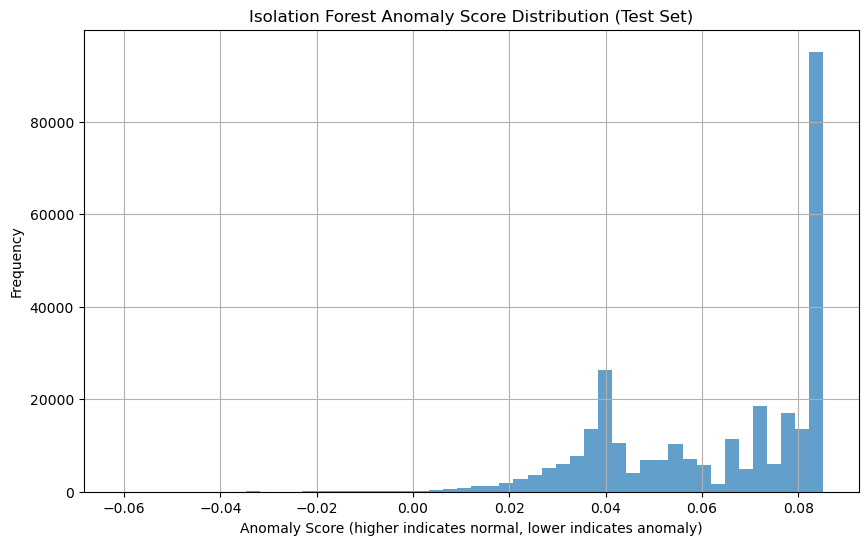

In [4]:
## Create a plot of the anomaly score distribution

plt.figure(figsize=(10, 6))
plt.hist(test_scores, bins=50, alpha=0.7)
plt.title("Isolation Forest Anomaly Score Distribution (Test Set)")
plt.xlabel("Anomaly Score (higher indicates normal, lower indicates anomaly)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

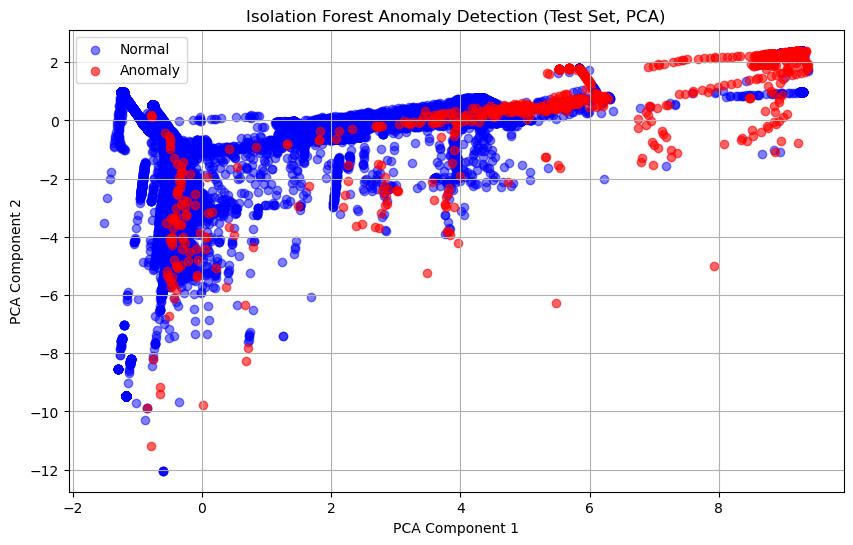

In [5]:
## Create a 2D PCA plot showing test datapoints.

pca = PCA(n_components=2)
x_test_pca = pca.fit_transform(x_test)

plt.figure(figsize=(10, 6))
plt.scatter(x_test_pca[test_preds == 1, 0], x_test_pca[test_preds == 1, 1], 
            c='blue', alpha=0.5, label='Normal')
plt.scatter(x_test_pca[test_preds == -1, 0], x_test_pca[test_preds == -1, 1], 
            c='red', alpha=0.6, label='Anomaly')

plt.title("Isolation Forest Anomaly Detection (Test Set, PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

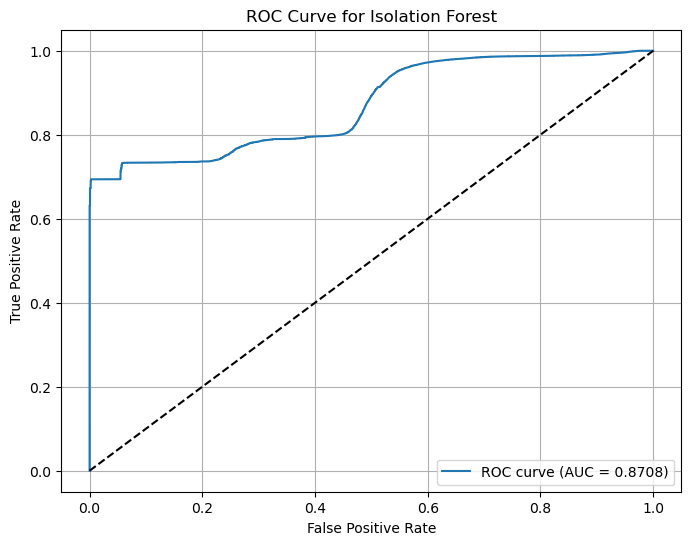

ROC AUC Score: 0.8708


In [6]:
## ROC AUC Curve
# Evaluates the performance of binary classification models. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) -
# at different thresholds showing how well a model can distinguish between two classes.

# AUC (Area Under the Curve) measures the area under the ROC curve. A higher AUC suggests better model performance; as it can distinguish between the classes better.
# An AUC of 1 means that the model is perfectly distinguishing the classes of datapoints. 0.5 Suggests that the model is essentially randomly guessing.

# Convert y_test to binary: 1 for normal, -1 for anomaly (ROC AUC is for binary classification only)
y_test_binary = np.where(y_test == 0, 1, -1)

fpr, tpr, thresholds = roc_curve(y_test_binary, test_scores)
roc_auc = roc_auc_score(y_test_binary, test_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Isolation Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

In [7]:
## Get the Root Mean Squared Error - RMSE measures the average magnitude of the errors between predicted and actual values.
# It is considered an excellent general-puprose error metric for numerical predictions.
# A lower score is better, it is feature dependend, sensitive to outliers but an easy way to compare models.


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, test_scores)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.6371416967980182
